In [6]:
import random
import simpy
import statistics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from os.path import exists
from os import mkdir
from scipy.interpolate import interp1d
from math import factorial
import seaborn as sns
import pandas as pd
from scipy import stats

from assignment_analytical import *
from assignment_util import *
from assignment_queue import *

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 11
mpl.rcParams["font.size"] = 11

#plt.rc("text", usetex=True)
# plt.rc("text.latex", preamble=r"""
# \usepackage{palatino}
# \usepackage{newpxmath}""")
#plt.rc("font", family="serif")


SAVEDIR = "save_data"
PLOTDIR = "plots"

DIRS = [SAVEDIR, PLOTDIR]

def savepath(filename):
    return SAVEDIR + f"/{filename}"

def plot_savepath(filename):
    return PLOTDIR + f"/{filename}"

for d in DIRS:
    if not exists(d):
        mkdir(d)

In [2]:
# TODO: one-sample t-tests for comparing simulated waiting time with analytical asymptotic waiting time?
# TOOD: one-tailed t-tests for 

In [2]:
def compute_difference(values):
    
    """
    Returns difference the last element of the array
    and the individual elements of the array.
    """
    
    i = [c for c in values]
    max_value = i[-1]

    return np.abs(i - max_value)



def dashed_heading(text, length):
    
    """
    Pretty printing headings flanked by dashes.
    """
    
    dash_length = max(length - len(text), 0)
    ldash_length = dash_length // 2
    rdash_length = dash_length - ldash_length
    ldash = "-" * ldash_length
    rdash = "-" * rdash_length
    return ldash + text + rdash



def welch_ttest(x, y): 
    
    # TODO: change for one-tailed
    """
    Parameteric two-sample Welch test for comparing the expectation values of two
    distributions when their second cumulants are not known.
    
    Prints the results of the test.
    """
    ## Welch-Satterthwaite Degrees of Freedom ##
    
    x_size = len(x)
    x_smean = np.mean(x)
    x_svar = np.sum(np.power(x - x_smean, 2)) / (x_size-1)
    
    y_size = len(y)
    y_smean = np.mean(y)
    y_svar = np.sum(np.power(y - y_smean, 2)) / (y_size-1)
    
    
    dof = (x_svar/x_size + y_svar/y_size)**2 / ((x_svar/x_size)**2 / (x_size-1) + (y_svar/x_size**2 / (x_size-1)))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print( 
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}", 
          dashed_heading("", 80))

In [3]:
"""
Varying ρ-values for M/M/1, 100 runs.

"""

random.seed(0x101ca7)
SIM_TIME = 10**5
μ = 1.0
ρ_values = np.linspace(0, 1, 11)[1:10]
number_of_runs = 100
λ_values = ρ_values * μ

N = len(ρ_values)

waiting_times = np.zeros((N, number_of_runs))

server_count = 1
service_t_dist = exp_factory(μ)

filename = "different_rhos_refactor.npz"
filepath = savepath(filename)

if not exists(filepath):
    for i,ρ in enumerate(ρ_values):
        print(f"===ρ={ρ}===")
        for run in range(number_of_runs):
            λ = λ_values[i]
            interarrival_t_dist = exp_factory(λ)
            
            env = simpy.Environment()
            system = System(env, server_count, service_t_dist)
            
            system.env.process(sim_setup(system, interarrival_t_dist))
            system.env.run(until = SIM_TIME)
            
            waiting_times[i][run] = np.mean(system.ts_waiting)
        
    np.savez(filepath, waiting_times)
    
else:
    save_data = np.load(filepath)
    waiting_times = save_data['arr_0']

In [7]:
def rhos_plotter(simulation_data, title):
    
    """ 
    Plots estimated mean waiting time for different ρ-values together with 
    analytical mean waiting time for given ρ-values.
    
    """
    
    filename = simulation_data
    filepath = savepath(filename)
    
    data = np.load(filepath)['arr_0']
    
    wt_means = []
    wt_variance = []
    
    for i in data:
        mean, variance = sample_mean_variance(i)
        wt_means.append(mean)
        wt_variance.append(variance)
        
    std = np.sqrt(wt_variance) 
    
    n = 100 # number of runs
    
    μ = 1.0
    ρ_values = np.linspace(0, 1, 11)[1:10]
    λ_values = ρ_values * μ
    
    # For plotting analytical estimate
    analytical_waiting_times = np.zeros(len(ρ_values))
    for i,ρ in enumerate(ρ_values):
        λ = μ * ρ
        analytical_waiting_times[i] = MM1_waiting_time(λ, μ)
    
    print("Analytical waiting times for ρ = 0.5: " + str(analytical_waiting_times[4]))
    print("Analytical waiting times for ρ = 0.6: {0:.2f} ".format(analytical_waiting_times[5]))
    print("Analytical waiting times for ρ = 0.7: {0:.2f} ".format(analytical_waiting_times[6]))
    print("Analytical waiting times for ρ = 0.8: {0:.2f} ".format(analytical_waiting_times[7]))
    print("Analytical waiting times for ρ = 0.9: {0:.2f} ".format(analytical_waiting_times[8]))
    
    conf_95 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(wt_variance)/np.sqrt(n)
    
    print("Mean waiting time ± CI (95%) ρ = 0.6: {0:4f} ± {1:4f}".format(wt_means[5], conf_95[5]))
    
    print("Mean waiting time ± CI (95%) ρ = 0.7: {0:4f} ± {1:4f}".format(wt_means[6], conf_95[6]))
    
    print("Mean waiting time ± CI (95%) ρ = 0.8: {0:4f} ± {1:4f}".format(wt_means[7], conf_95[7]))
    
    print("Mean waiting time ± CI (95%) ρ = 0.9: {0:4f} ± {1:4f}".format(wt_means[8], conf_95[8]))
    
    plt.plot(ρ_values, wt_means, alpha = 0.5, marker = "h", color = "maroon", label = "simulated: 100 runs")
    plt.plot(ρ_values, analytical_waiting_times, alpha = 0.5, marker = "d", markersize = 3, linestyle = "--", color = "black", label = "analytical")
    plt.fill_between(ρ_values, wt_means - std, wt_means + std, alpha = 0.3, color = 'maroon')
    plt.legend()
    plt.grid()
    plt.xlabel("System load, ρ")
    
    plt.ylabel(r"Mean waiting time, $\langle \overline{T}_q \rangle$ and SD")
    
    title = plot_savepath(title)
    plt.savefig(title)
    plt.show()

Analytical waiting times for ρ = 0.5: 1.0
Analytical waiting times for ρ = 0.6: 1.50 
Analytical waiting times for ρ = 0.7: 2.33 
Analytical waiting times for ρ = 0.8: 4.00 
Analytical waiting times for ρ = 0.9: 9.00 
Mean waiting time ± CI (95%) ρ = 0.6: 1.497590 ± 0.006556
Mean waiting time ± CI (95%) ρ = 0.7: 2.328624 ± 0.013401
Mean waiting time ± CI (95%) ρ = 0.8: 3.997041 ± 0.031576
Mean waiting time ± CI (95%) ρ = 0.9: 8.925302 ± 0.128993


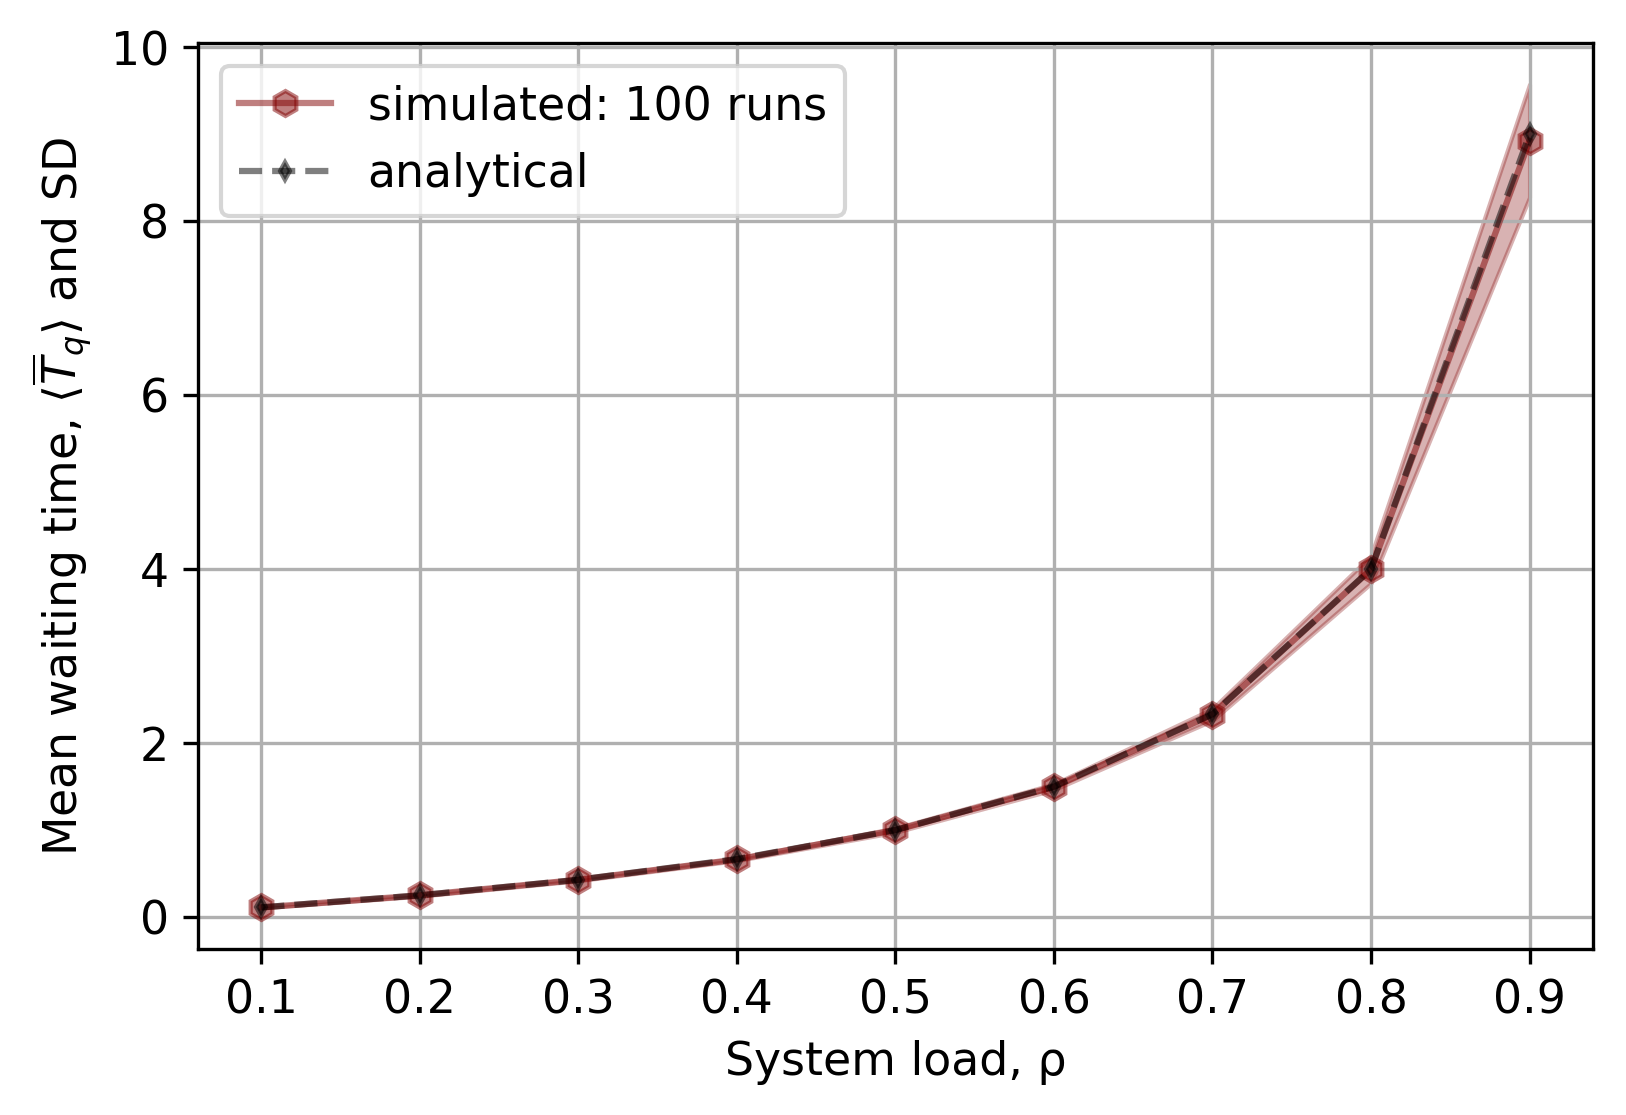

In [8]:
#rhos_plotter("different_rhos_refactor.npz", "different_rhos_refactor.png")
#Saving as pdf
rhos_plotter("different_rhos_refactor.npz", "different_rhos_refactor.pdf")

In [21]:
"""
Transient to steady-state (varying simulation time) 
for ρ-values: 0.5, 0.6, 0.7, 0.8, 0.9.

"""

simulation_times = np.logspace(2, 6, num = 5, base = 10)
# server_counts = np.array([1,2,4])
μ = 1.0
ρ_values = np.linspace(0, 1, 11)[5:-1]
number_of_runs = 20

service_t_dist = exp_factory(μ)

# n1 = len(server_counts)
n2 = len(ρ_values)
n3 = len(simulation_times)

mean_waiting_times = np.zeros((n2, n3))
svar_waiting_times = np.zeros((n2, n3))

filename = "transient_to_SS.npz"
filepath = savepath(filename)


if not exists(filepath):
    for j, ρ in enumerate(ρ_values):
        print(f"ρ = {ρ}")
        λ = μ * ρ
        interarrival_t_dist = exp_factory(λ)
        for k, T in enumerate(simulation_times):
            print(f"Simulation time = {T}")
            batch_means = np.zeros(number_of_runs)
            for l in range(number_of_runs):
                env = simpy.Environment()
                system = System(env, 1, service_t_dist)
                system.env.process(sim_setup(system, interarrival_t_dist))
                system.env.run(until = T)
                batch_means[l] = np.mean(system.ts_waiting)
            smean, svar = sample_mean_variance(batch_means)
            mean_waiting_times[j][k] = smean
            svar_waiting_times[j][k] = svar
    np.savez(filepath, mean_waiting_times, svar_waiting_times)
else:
    save_data = np.load(filepath)
    mean_waiting_times = save_data['arr_0']
    svar_waiting_times = save_data['arr_1']

In [9]:
def varying_sim_time_plotter(simulation_data, title, rho):

    """
    Plots mean waiting time and confidence intervals accross simulated times for
    different ρ-values.

    """

    filename = simulation_data
    filepath = savepath(filename)
    
    data = np.load(filepath)
    
    mean_waiting_times = data['arr_0']
    svar_waiting_times = data['arr_1']
    
    μ = 1.0
    ρ_values = np.linspace(0, 1, 11)[5:-1]
    λ_values = ρ_values * μ
    
    # For plotting analytical estimate
    analytical_waiting_times = np.zeros(len(ρ_values))
    for i,ρ in enumerate(ρ_values):
        λ = μ * ρ
        analytical_waiting_times[i] = MM1_waiting_time(λ, μ)

    
    if rho == 0.5:
        mean = mean_waiting_times[0]
        svar = svar_waiting_times[0]
        analytical_wt = analytical_waiting_times[0]

    elif rho == 0.6:
        mean = mean_waiting_times[1]
        svar = svar_waiting_times[1]
        analytical_wt = analytical_waiting_times[1]

    elif rho == 0.7:
        mean = mean_waiting_times[2]
        svar = svar_waiting_times[2]
        analytical_wt = analytical_waiting_times[2]
        
    elif rho == 0.8:
        mean = mean_waiting_times[3]
        svar = svar_waiting_times[3]
        analytical_wt = analytical_waiting_times[3]
    
    elif rho == 0.9:
        mean = mean_waiting_times[4]
        svar = svar_waiting_times[4]
        analytical_wt = analytical_waiting_times[4]
    
    
    simulation_times = np.logspace(2, 6, num = 5, base = 10)
    std = np.sqrt(svar) 

    n = 20 # number of runs
    
    conf_95 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(svar)/np.sqrt(n)
   
    difference = compute_difference(values = conf_95)

    ax = plt.gca() 

    plt.plot(simulation_times, mean, alpha = 0.5, color = "darkred", marker = "h") # label = "$ρ = $" + str(rho))
    plt.fill_between(simulation_times, mean - conf_95, mean + conf_95, alpha = 0.3, color = "darkred")
    plt.hlines(analytical_wt, simulation_times[0], simulation_times[-1], label = "analytical ${T}_q$", linestyles="dashed", linewidth = 2, color = "darkblue", alpha = 0.7)
    
    plt.xlabel("Simulation time")
    plt.xscale('log')
    
    plt.legend()
    ax.set_ylabel(r"Mean waiting time, $\langle \overline{T}_q \rangle$ and 95% CI", color = "darkred")
    plt.grid(True)
    
    ax2 = ax.twinx()
    ax2.plot(simulation_times, difference, color = 'black', marker = "D", markersize = 4, linestyle = "-.", alpha = 0.7)
    for xitem, yitem in np.nditer([simulation_times, difference]):
        etiqueta = "{:.3f}".format(yitem)
        plt.annotate(etiqueta, (xitem, yitem), size = 11, color = "black", textcoords="offset points",xytext=(0,10),ha="center")
    ax2.tick_params(axis='y', labelcolor='black')
    if rho < 0.9:
        ax.set_ylim(0.06, 6)
        ax2.set_ylim(-0.4, 1.3)
    ax2.set_ylabel("Absolute difference in 95% CI", color = 'black')
    
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    plt.show()

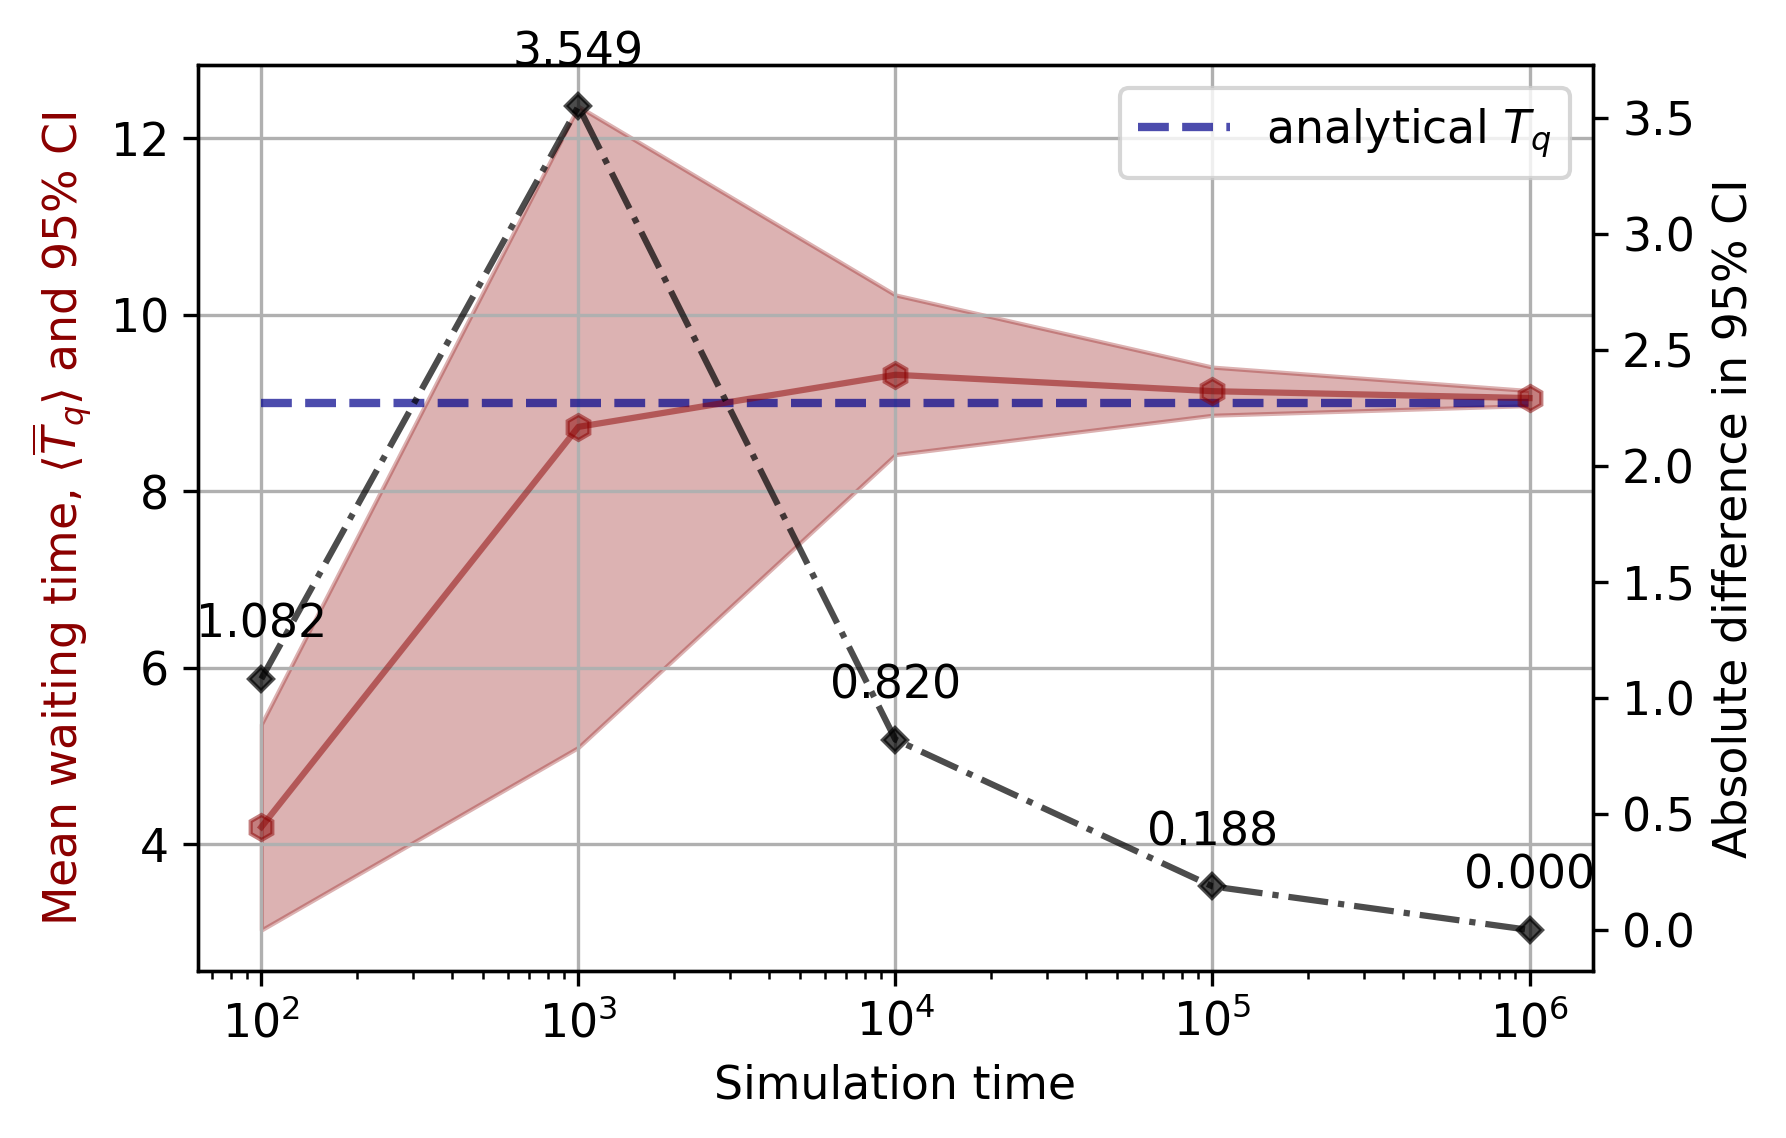

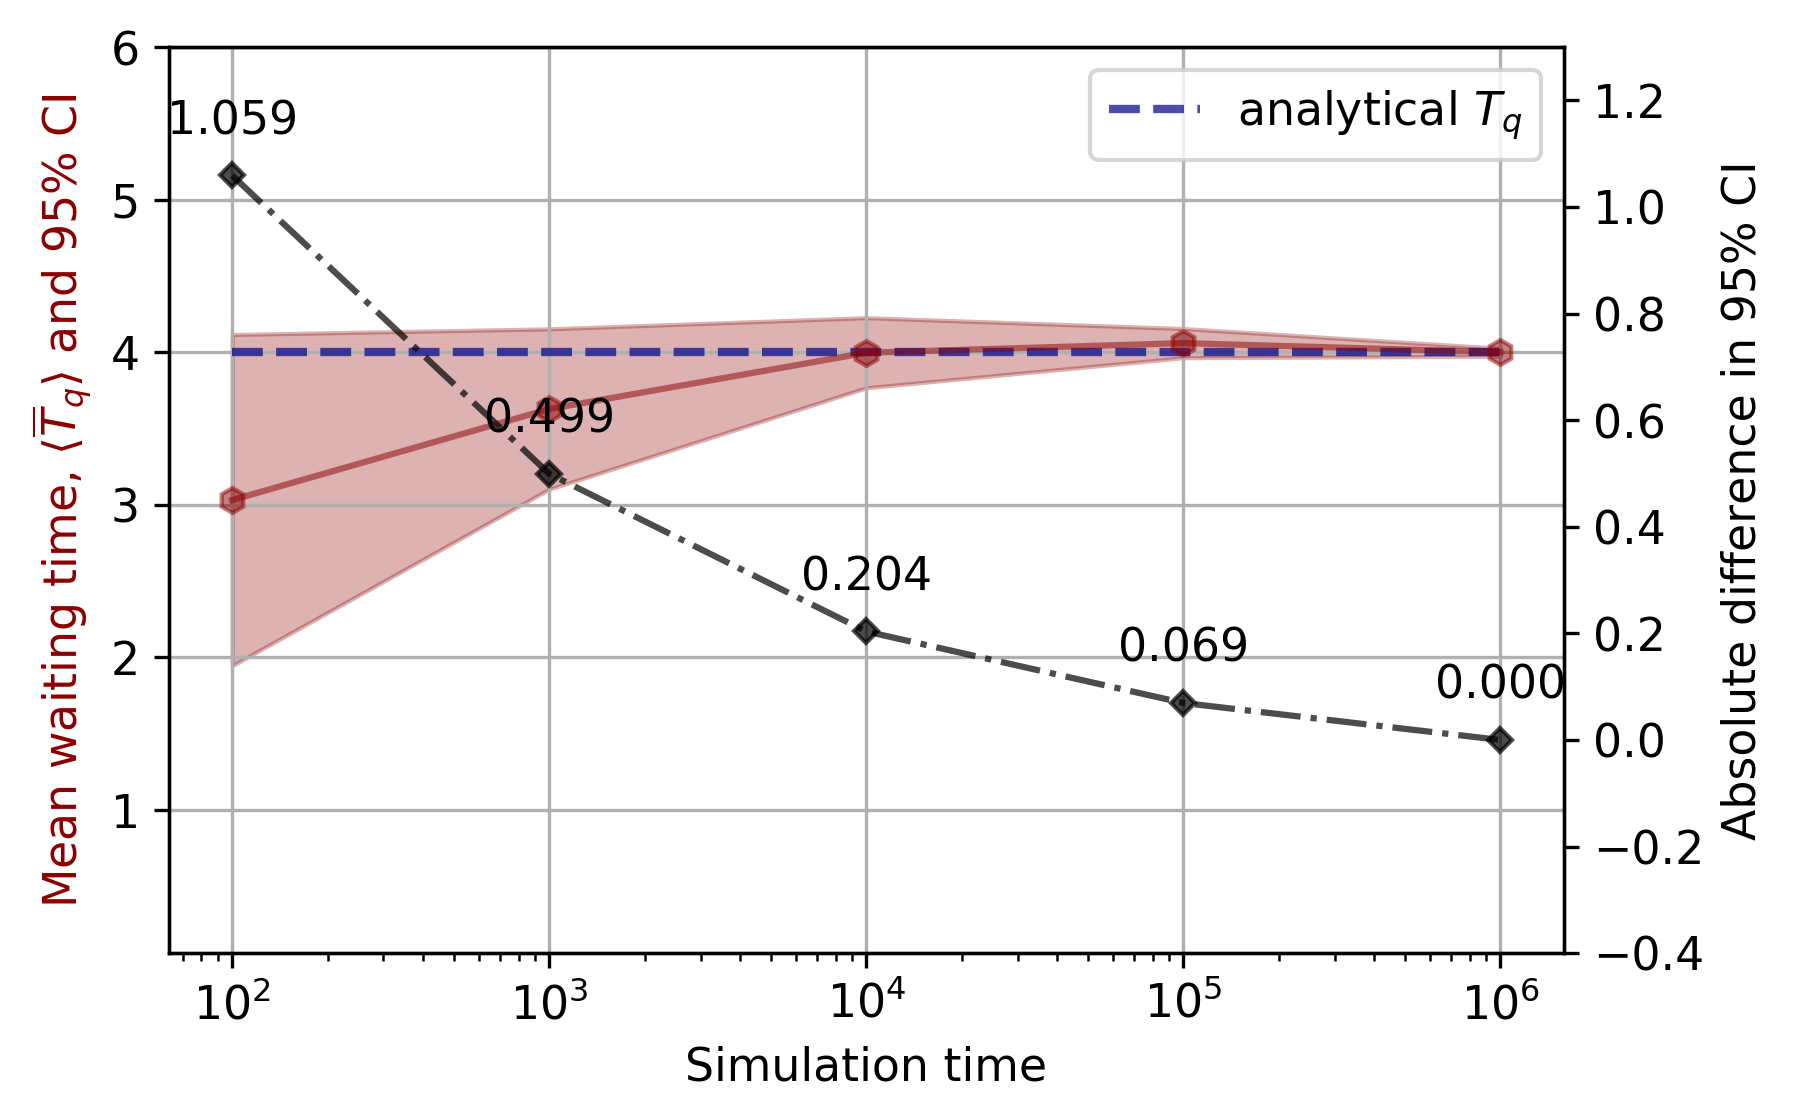

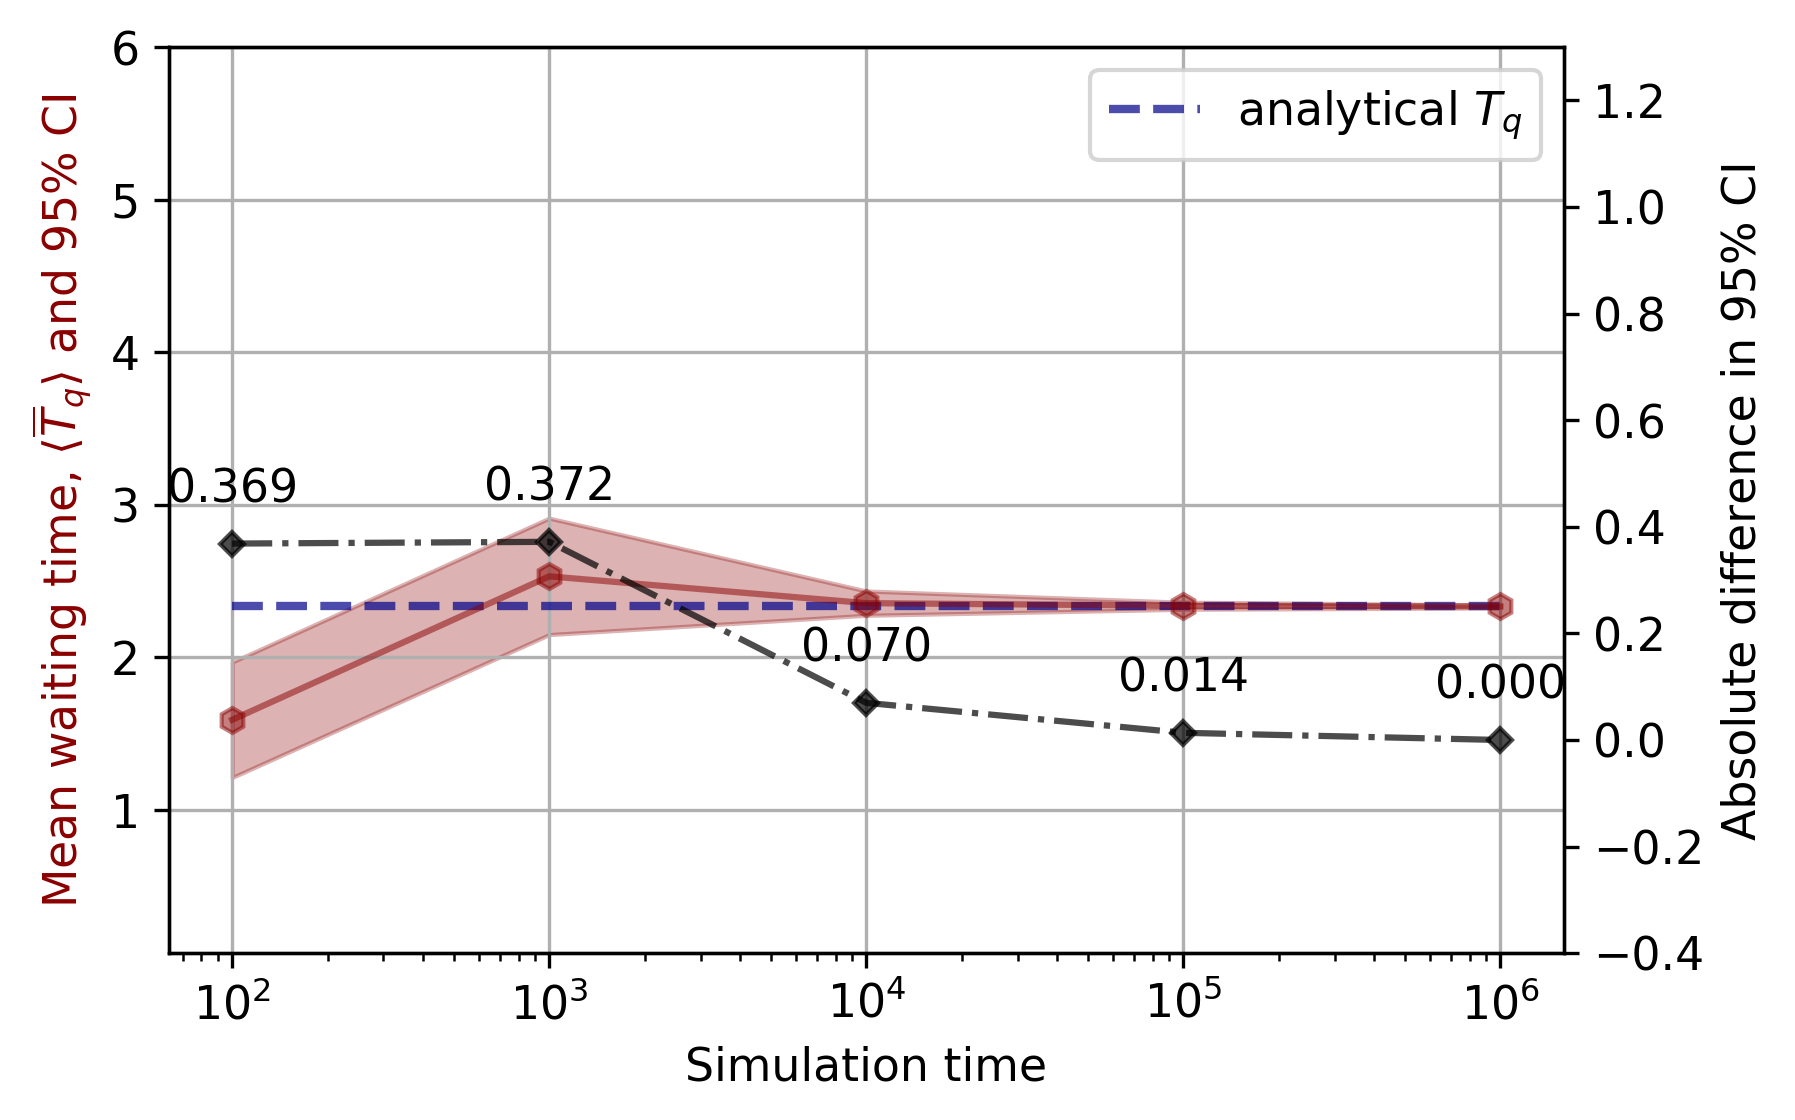

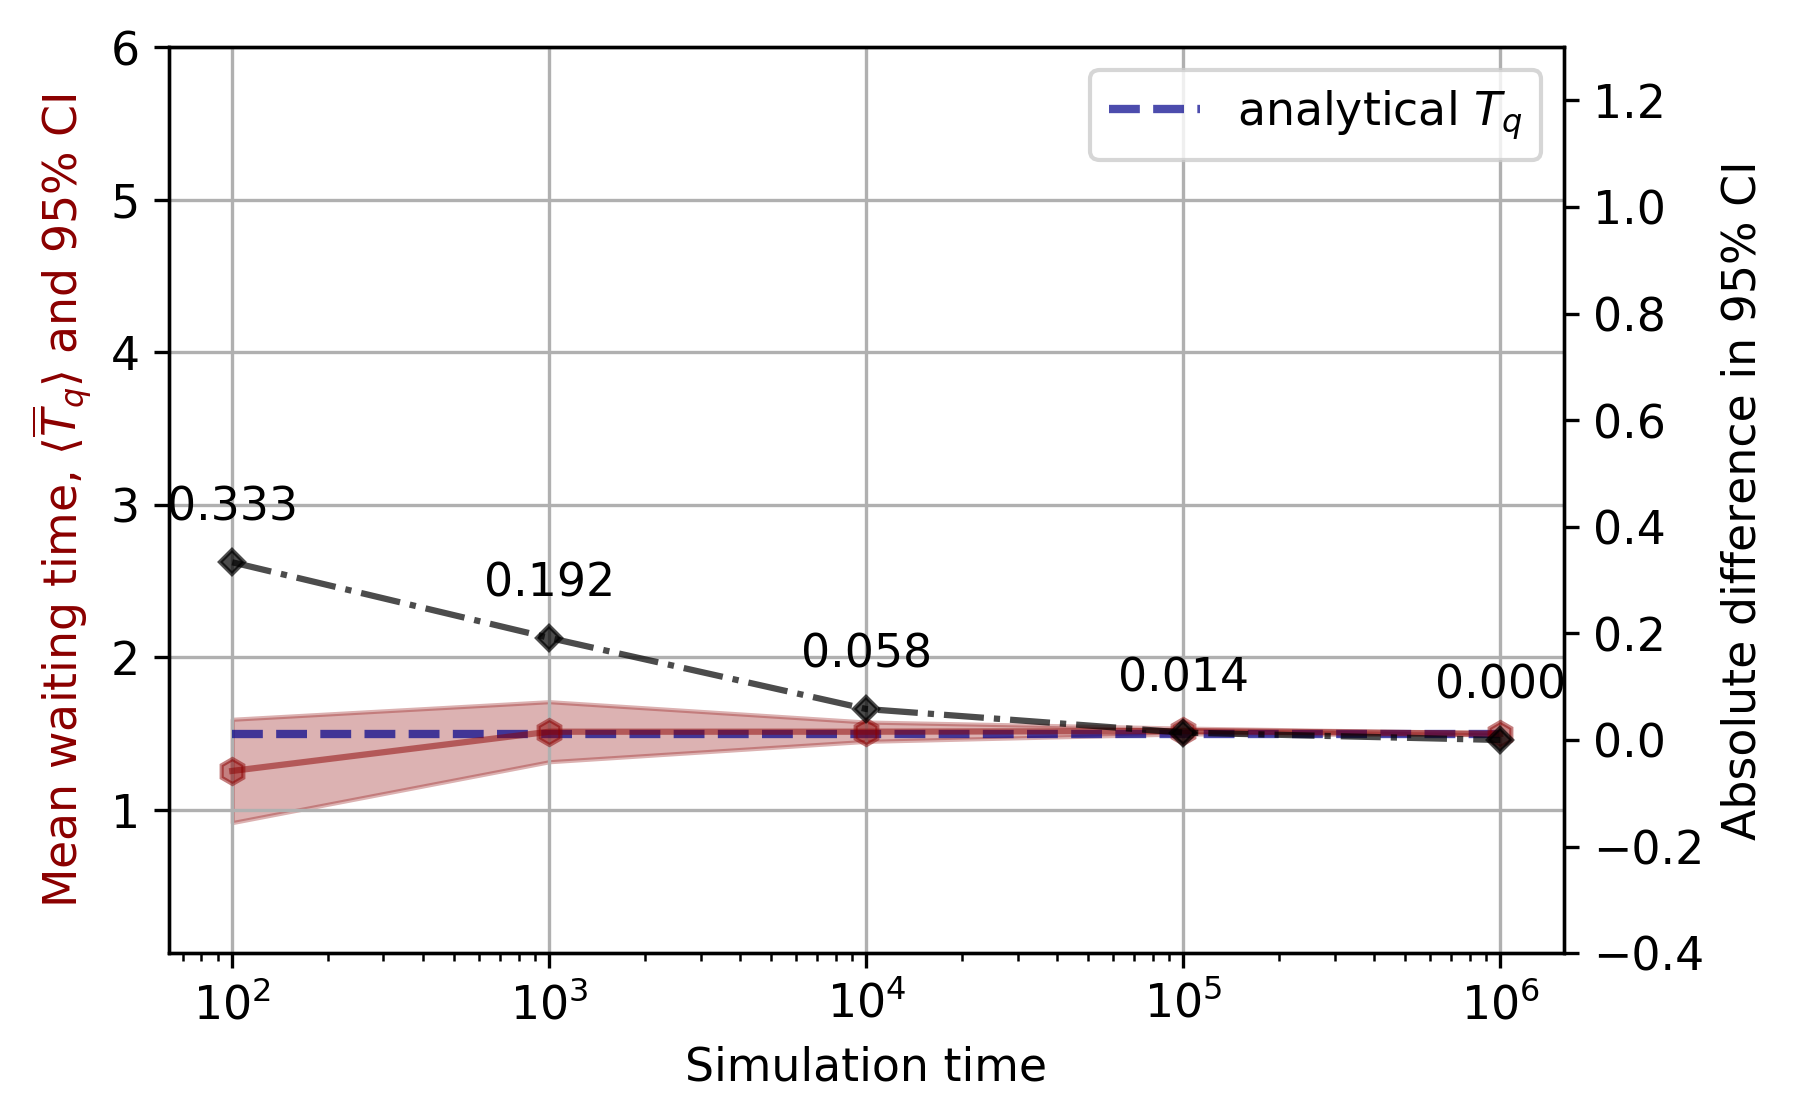

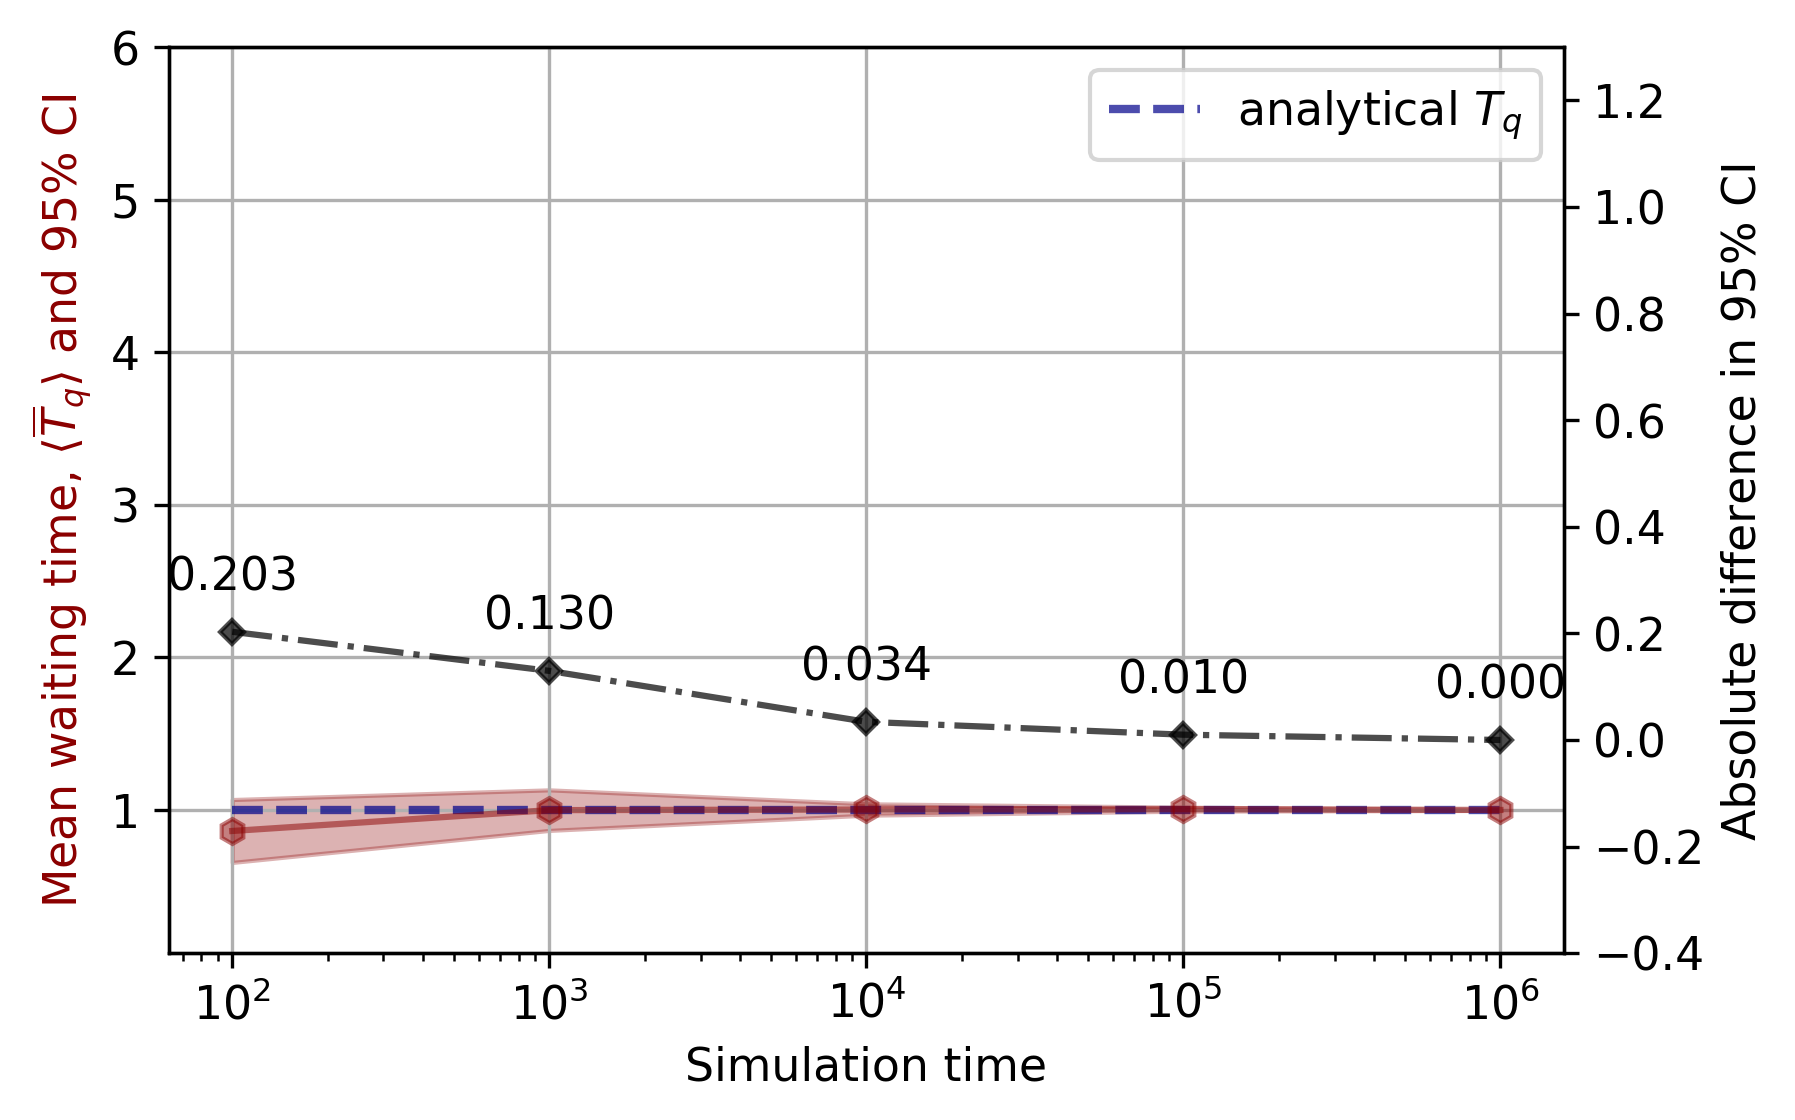

In [10]:
varying_sim_time_plotter(simulation_data = "transient_to_SS.npz", title = "Transient_to_SS_09.pdf", rho = 0.9)
varying_sim_time_plotter(simulation_data = "transient_to_SS.npz", title = "Transient_to_SS_08.pdf", rho = 0.8)
varying_sim_time_plotter(simulation_data = "transient_to_SS.npz", title = "Transient_to_SS_07.pdf", rho = 0.7)
varying_sim_time_plotter(simulation_data = "transient_to_SS.npz", title = "Transient_to_SS_06.pdf", rho = 0.6)
varying_sim_time_plotter(simulation_data = "transient_to_SS.npz", title = "Transient_to_SS_05.pdf", rho = 0.5)

In [37]:
"""
Saving data for histograms and bar plots: M/M/1, M/M/2, M/M/4, 100 runs.

"""

random.seed(0x101ca7)
SIM_TIME = 10**5
server_counts = np.array([1,2,4])

number_of_runs = 100

ρ = 0.9
μ = 1.0
λ_values = [μ*ρ*n for n in server_counts]

waiting_times = np.zeros((len(server_counts), number_of_runs))

service_t_dist = exp_factory(μ)

filename = "waiting_times_fullsave_124.npz"
filepath = savepath(filename)

if not exists(filepath):
    for i, n in enumerate(server_counts):
        print(f"===M/M/{n}===")
        for run in range(number_of_runs):
            if run % 10 == 0:
                print(f"Done with {run} out of {number_of_runs} runs")
            λ = λ_values[i]
            interarrival_t_dist = exp_factory(λ)
            
            env = simpy.Environment()
            system = System(env, n, service_t_dist)
            
            system.env.process(sim_setup(system, interarrival_t_dist))
            system.env.run(until = SIM_TIME)
            waiting_times[i][run] = np.mean(system.ts_waiting) #waiting time, not sojourn
    
    np.savez(filepath, waiting_times)
else:
    _save_data = np.load(filepath)
    waiting_times = _save_data['arr_0']

In [38]:
#TODO: Delete one of the two cells: this one or previous


random.seed(0x101ca7)
SIM_TIME = 10**5
server_counts = np.array([1,2,4])

number_of_runs = 100

ρ = 0.9
μ = 1.0
λ_values = [μ*ρ*n for n in server_counts]

waiting_times = np.zeros((len(server_counts), number_of_runs))

service_t_dist = exp_factory(μ)

filename = "waiting_times_fullsave_124.npz"
filepath = savepath(filename)

if not exists(filepath):
    for i, n in enumerate(server_counts):
        print(f"===M/M/{n}===")
        for run in range(number_of_runs):
            if run % 10 == 0:
                print(f"Done with {run} out of {number_of_runs} runs")
            λ = λ_values[i]
            interarrival_t_dist = exp_factory(λ)
            
            env = simpy.Environment()
            system = System(env, n, service_t_dist)
            
            system.env.process(sim_setup(system, interarrival_t_dist))
            system.env.run(until = SIM_TIME)
            waiting_times[i][run] = np.mean(system.ts_waiting) #waiting time, not sojourn
    
    np.savez(filepath, waiting_times)
else:
    _save_data = np.load(filepath)
    waiting_times = _save_data['arr_0']

assert len(waiting_times) == len(server_counts)

for wtimes in waiting_times:
    assert len(wtimes) == number_of_runs

In [11]:
def histogram_plotter(simulation_data, title):
    
    """
    Plots histogram and distribution from the simulation data
    using seaborn `displot`
    
    Used for plotting results of M/D/n and M/H/n queues
    
    """
    
    filename = simulation_data
    filepath = savepath(filename)
    
    data = np.load(filepath)['arr_0']
    
    data = np.load(filepath)['arr_0']
    n = 100

    mean_1, variance_1 = sample_mean_variance(data[0])
    conf_95_1 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_1)/np.sqrt(n)
    
    mean_2, variance_2 = sample_mean_variance(data[1])
    conf_95_2 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_2)/np.sqrt(n)
    
    mean_4, variance_4 = sample_mean_variance(data[2])
    conf_95_4 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_4)/np.sqrt(n)
    
    print("Mean waiting time ± CI (95%) for 1-server queue: {0:4f} ± {1:4f}".format(mean_1, conf_95_1))
    
    print("Mean waiting time ± CI (95%) for 2-server queue: {0:4f} ± {1:4f}".format(mean_2, conf_95_2))
    
    print("Mean waiting time ± CI (95%) for 4-server queue: {0:4f} ± {1:4f}".format(mean_4, conf_95_4))
    
    df = pd.DataFrame((data), index=["1", "2", "4"])
    
    df_t = df.T
    
    palette = sns.xkcd_palette(['forest green', 'bright red', 'dull blue'])

    sns.set_style("ticks", 
                  {"xtick.major.size":8, "ytick.major.size":8, 'axes.grid': True})
    
#   sns.axes_style("whitegrid")
    fig = sns.displot(df_t, bins = 45, kde = True, legend = False, palette=palette, height=4, aspect=0.9) #husl"CMRmap_r"
    
    plt.xlabel(r"Mean waiting time, $\langle \overline{T}_q \rangle$")
    
    plt.legend(loc = 1, title = "Number of servers (n)", labels= ["4", "2", "1"])
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    
    plt.show()


Mean waiting time ± CI (95%) for 1-server queue: 9.018165 ± 0.114256
Mean waiting time ± CI (95%) for 2-server queue: 4.282069 ± 0.040814
Mean waiting time ± CI (95%) for 4-server queue: 1.964095 ± 0.015482


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


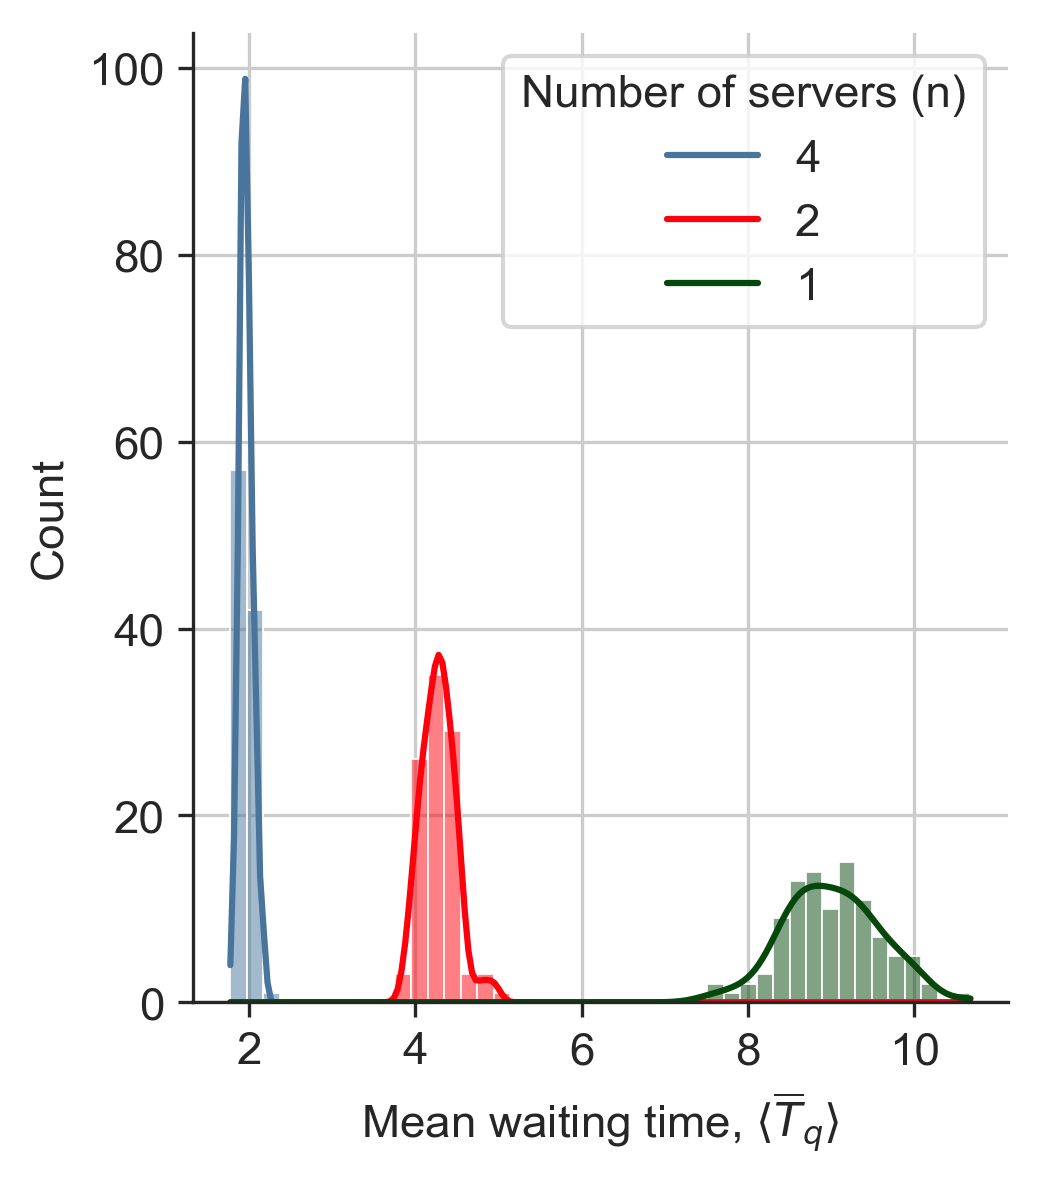

In [12]:
histogram_plotter(simulation_data = "waiting_times_fullsave_124.npz", title = "fullsize_Markovian_histogram.pdf")

In [13]:
def boxplot_plotter(simulation_data, title):
    
    """
    Plots boxplot from simualation data 
    using seaborn's boxplot
    
    Return t-test results
    
    """
    
    filename = simulation_data
    filepath = savepath(filename)
    
    data = np.load(filepath)['arr_0']
        
    print("Pair-wise Welch-test:")
    print("M/M/1 and M/M/2:")
    welch_ttest(data[0], data[1])
    
    print("M/M/1 and M/M/4:")
    welch_ttest(data[0], data[2])
    
    print("M/M/2 and M/M/4:")
    welch_ttest(data[1], data[2])
        
    palette = sns.xkcd_palette(['forest green', 'bright red', 'dull blue'])
    
    df = pd.DataFrame(np.transpose(data), columns = ["1", "2", "4"])
    
    plt.figure(figsize=(4,5))
    fig = sns.boxplot(data=df, palette=palette, notch=True, linewidth=0.4, 
                 fliersize=2, width = 0.6, flierprops=dict(marker='o', markersize=2))
    
    plt.xlabel("Number of servers, n")
    plt.ylabel(r"Mean waiting time, $\langle \overline{T}_q \rangle$")
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    plt.show()


Pair-wise Welch-test:
M/M/1 and M/M/2:
Welch's t-test= 77.4558 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 90.8965 --------------------------------------------------------------------------------
M/M/1 and M/M/4:
Welch's t-test= 121.3948 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 97.2817 --------------------------------------------------------------------------------
M/M/2 and M/M/4:
Welch's t-test= 105.3650 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 29.4339 --------------------------------------------------------------------------------


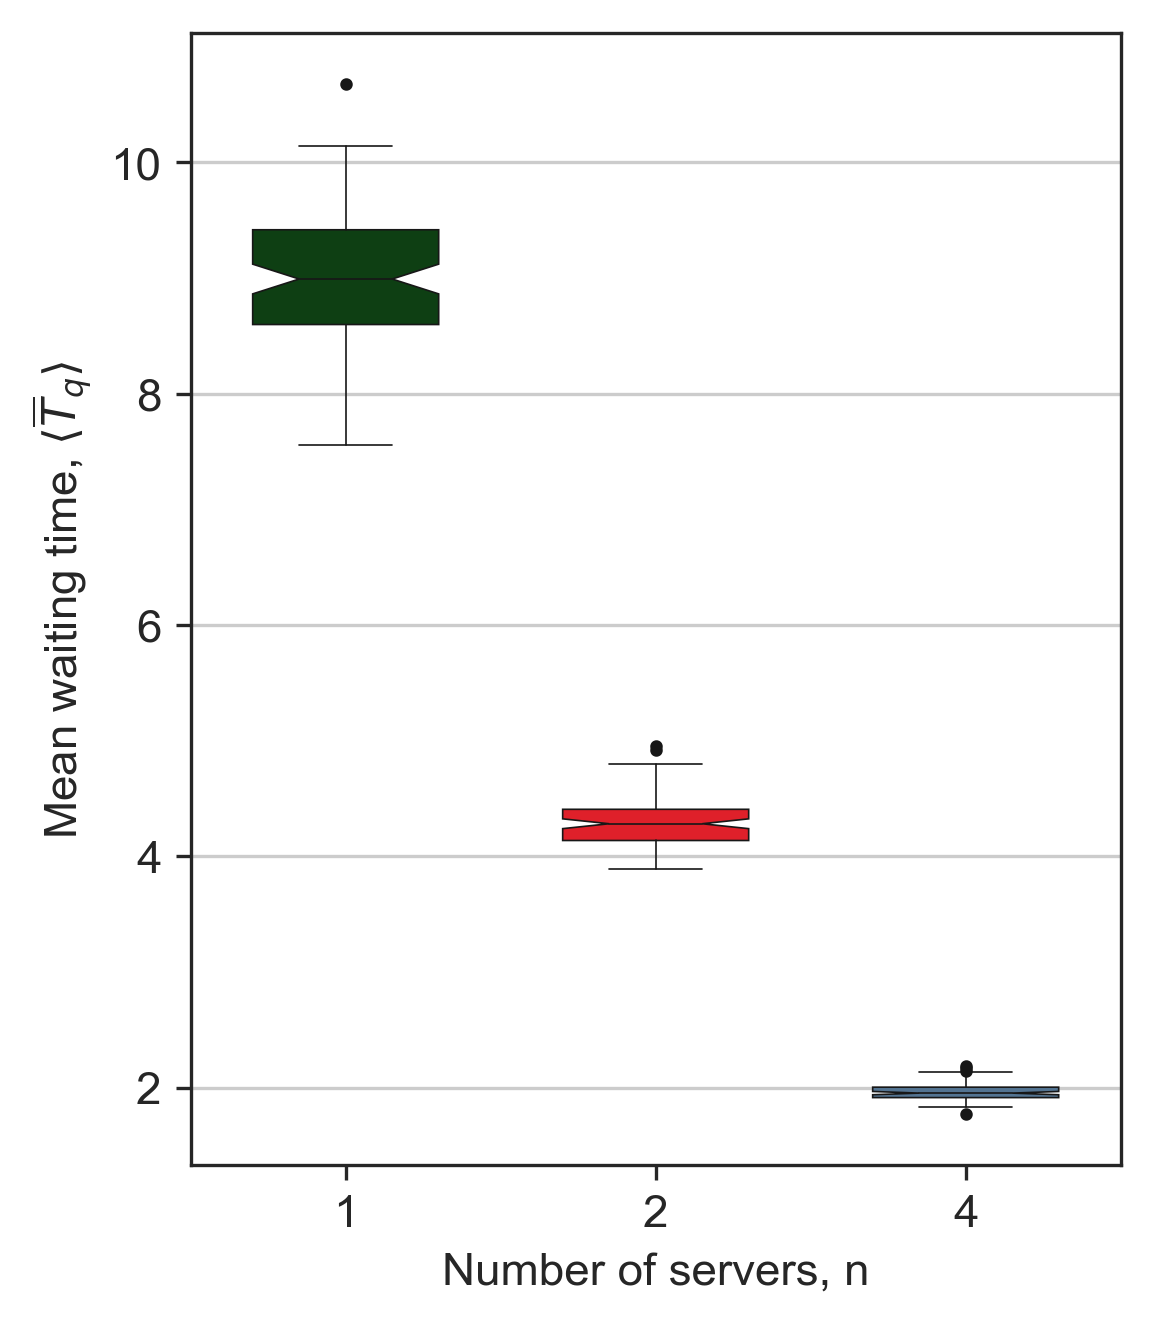

In [14]:
boxplot_plotter(simulation_data = "waiting_times_fullsave_124.npz", title = "Markovian_boxplot.pdf")

In [29]:
"""
M/M/1 SPTF, 100 runs.

"""

random.seed(0xc0ffee)
SIM_TIME = 10**5
μ = 1.0
ρ = 0.9
number_of_runs = 100
λ = ρ * μ

waiting_times = np.zeros(number_of_runs)

server_count = 1
service_t_dist = exp_factory(μ)
interarrival_t_dist = exp_factory(λ)

filename = "waiting_times_MM1_sptf.npz"
filepath = savepath(filename)

if not exists(filepath):
    for run in range(number_of_runs):
        if run % 5 == 0:
            print(f"{run} of {number_of_runs} done")
        env = simpy.Environment()
        system = System(env, server_count, service_t_dist, sptf = True)
        system.env.process(sim_setup(system, interarrival_t_dist))
        system.env.run(until = SIM_TIME)
        waiting_times[run] = np.mean(system.ts_waiting)
    print("done with all runs")
        
    np.savez(filepath, waiting_times)
    
else:
    save_data = np.load(filepath)
    waiting_times = save_data['arr_0']

In [15]:
def SPTF_FIFO_histogram_plotter(FIFO_data, SPTF_data, title):
    
    """
    Plots histogram and distribution from the simulation data
    using seaborn `displot`
    
    Used for plotting results of M/D/n and M/H/n queues
    
    """
    
    FIFO = np.load(savepath(FIFO_data))['arr_0']
    
    SPTF = np.load(savepath(SPTF_data))['arr_0']

    MM1_FIFO = FIFO[0]
    
    n = 100

    mean_FIFO, variance_FIFO = sample_mean_variance(MM1_FIFO)
    conf_95_FIFO = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_FIFO)/np.sqrt(n)
    
    mean_SPTF, variance_SPTF = sample_mean_variance(SPTF)
    conf_95_SPTF = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_SPTF)/np.sqrt(n)
    
    
    print("Mean waiting time ± CI (95%) for M/M/1 FIFO queue: {0:4f} ± {1:4f}".format(mean_FIFO, conf_95_FIFO))
    
    print("Mean waiting time ± CI (95%) for M/M/1 SPTF queue: {0:4f} ± {1:4f}".format(mean_SPTF, conf_95_SPTF))
    
    
    df = pd.DataFrame({'FIFO': MM1_FIFO, 'SPTF': SPTF})

    
    palette = sns.xkcd_palette(['forest green', 'faded orange'])

    sns.set_style("ticks", 
                  {"xtick.major.size":8, "ytick.major.size":8, 'axes.grid': True})
    
#   sns.axes_style("whitegrid")
    fig = sns.displot(df, bins = 32, kde = True, legend = False, palette=palette, height=4, aspect=0.9) #husl"CMRmap_r"
    
    plt.xlabel(r"Mean waiting time, $\langle \overline{T}_q \rangle$")
    
    plt.legend(loc = 1, title = "Scheduling discipline", labels= ["SPTF", "FIFO"])
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    
    plt.show()

Mean waiting time ± CI (95%) for M/M/1 FIFO queue: 9.018165 ± 0.114256
Mean waiting time ± CI (95%) for M/M/1 SPTF queue: 3.202565 ± 0.025121


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


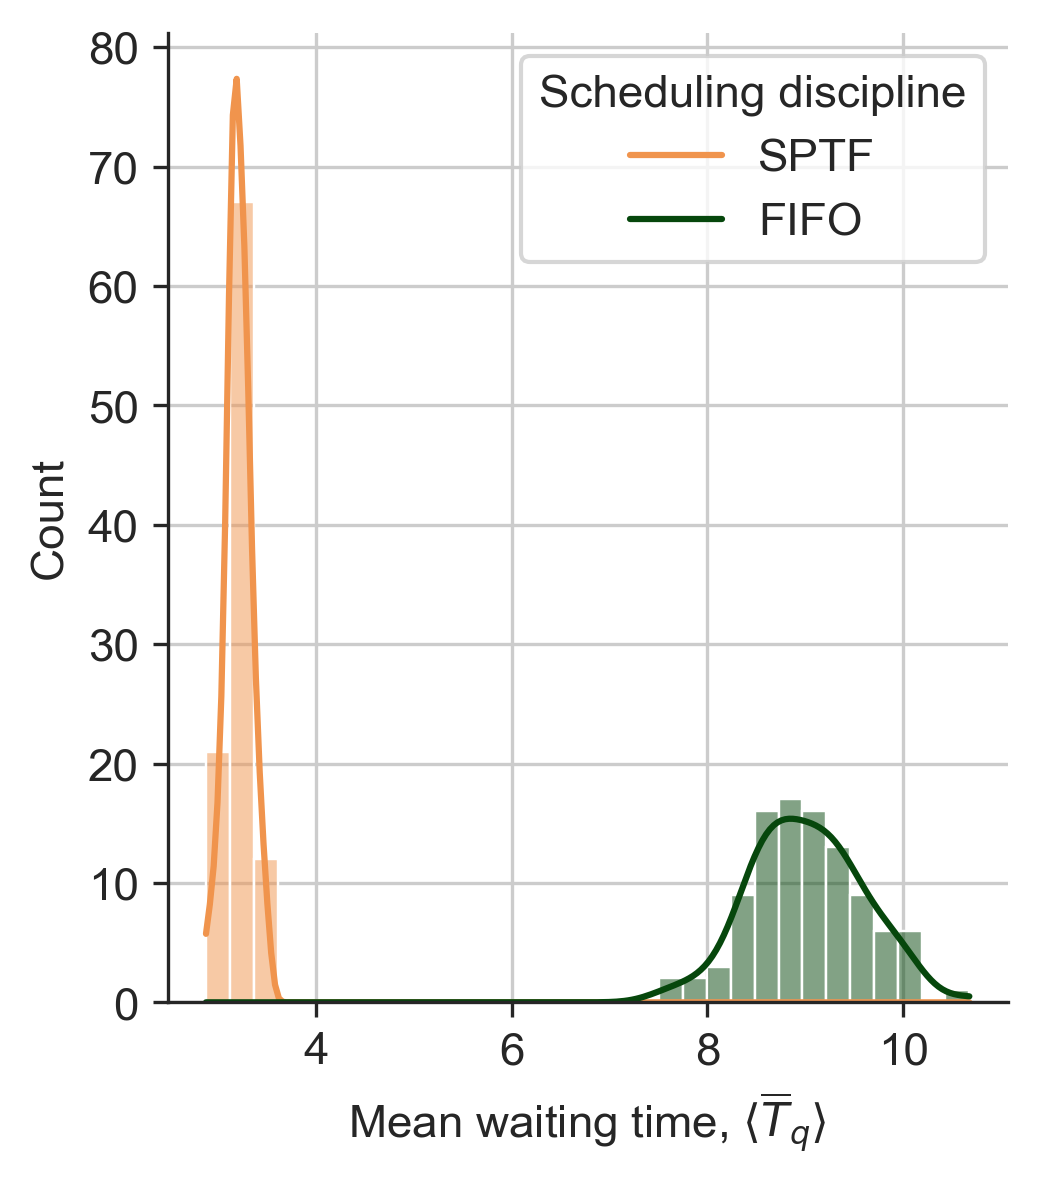

In [16]:
SPTF_FIFO_histogram_plotter(FIFO_data = "waiting_times_fullsave_124.npz", SPTF_data = "waiting_times_MM1_sptf.npz", title = "MM1_FIFO_SPTF_histogram.pdf")

In [17]:
def SPTF_FIFO_boxplot_plotter(FIFO_data, SPTF_data, title):
    
    """
    Plots boxplot from simualation data 
    using seaborn's boxplot
    
    Return t-test results
    
    """
    
    FIFO = np.load(savepath(FIFO_data))['arr_0']
    
    MM1_FIFO = FIFO[0]
    
    SPTF = np.load(savepath(SPTF_data))['arr_0']

    df = pd.DataFrame({'FIFO': MM1_FIFO, 'SPTF': SPTF})
        
    print("Pair-wise Welch-test:")
    print("M/M/1 FIFO and M/M/2 SPTF:")
    welch_ttest(MM1_FIFO, SPTF)
 
    palette = sns.xkcd_palette(['forest green', 'faded orange'])
  
    plt.figure(figsize=(4,5))
    fig = sns.boxplot(data=df, palette=palette, notch=True, linewidth=0.4, 
                 fliersize=2, width = 0.5, flierprops=dict(marker='o', markersize=2))
    
    plt.xlabel("Scheduling discipline")
    plt.ylabel(r"Mean waiting time, $\langle \overline{T}_q \rangle$")
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    plt.show()

Pair-wise Welch-test:
M/M/1 FIFO and M/M/2 SPTF:
Welch's t-test= 98.6403 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 94.9585 --------------------------------------------------------------------------------


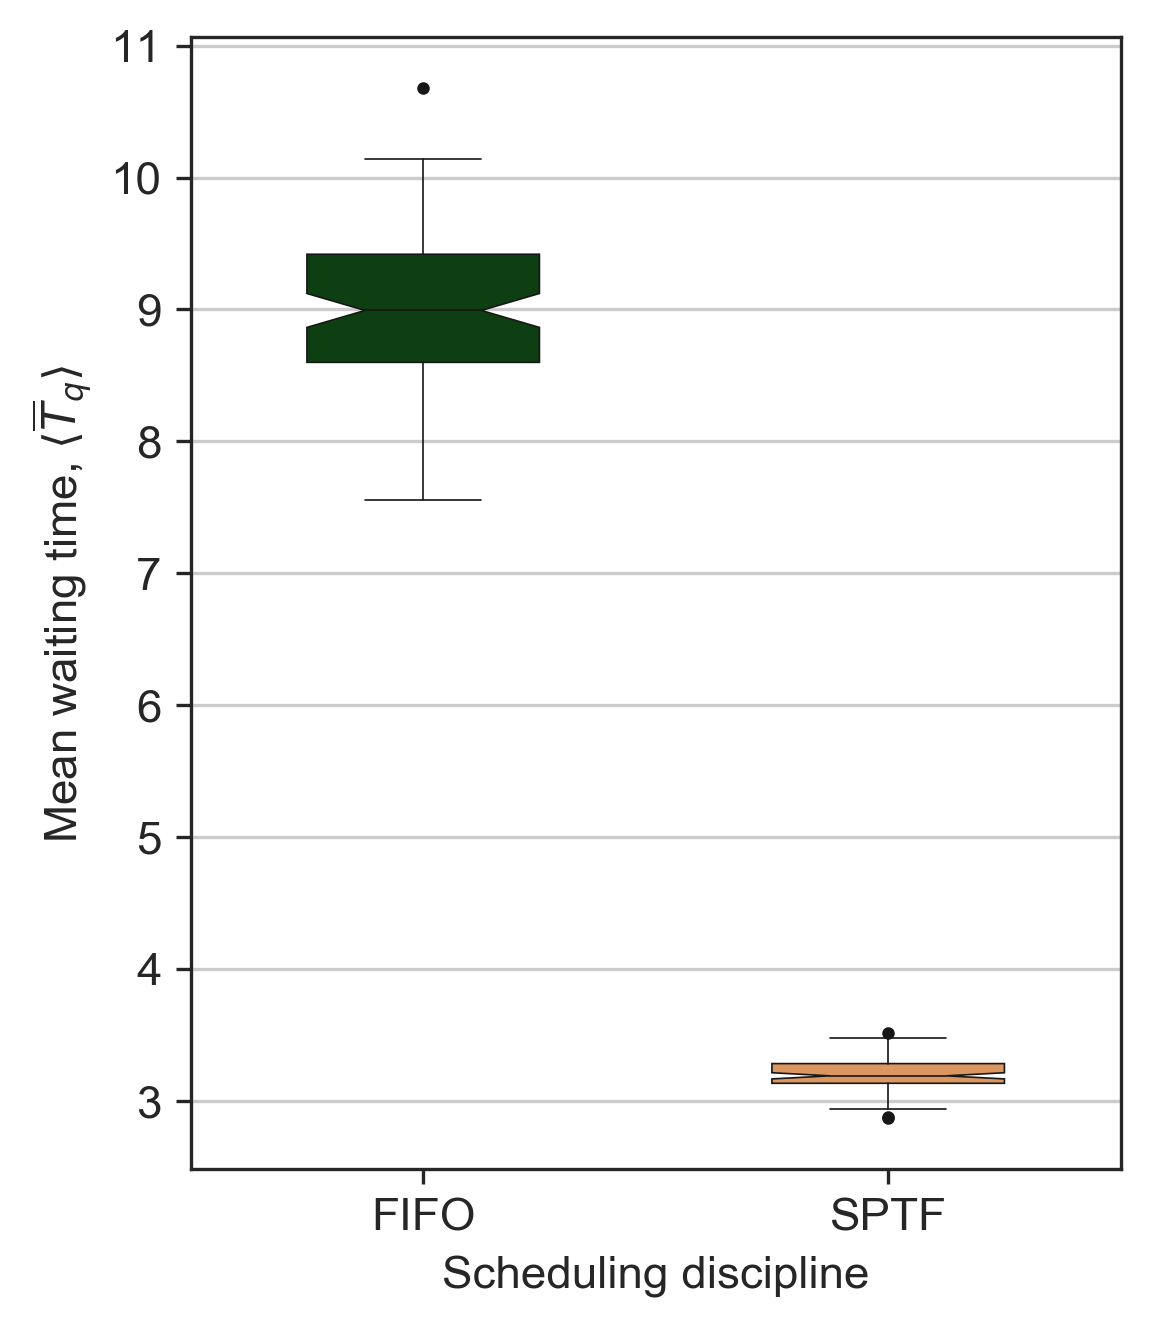

In [18]:
SPTF_FIFO_boxplot_plotter(FIFO_data = "waiting_times_fullsave_124.npz", SPTF_data = "waiting_times_MM1_sptf.npz", title = "MM1_FIFO_SPTF_boxplot.pdf")

In [36]:
"""
M/D/1, M/D/2, M/D/4, 100 runs.

"""

random.seed(0x101ca7)
SIM_TIME = 10**5
server_counts = np.array([1,2,4])

number_of_runs = 100

ρ = 0.9
μ = 1.0
λ_values = [μ*ρ*n for n in server_counts]

waiting_times = np.zeros((len(server_counts), number_of_runs))

service_t_dist = deterministic_factory(1/μ)

filename = "waiting_times_fullsave_124_deterministic.npz"
filepath = savepath(filename)

if not exists(filepath):
    for i, n in enumerate(server_counts):
        print(f"===M/D/{n}===")
        for run in range(number_of_runs):
            if run % 10 == 0:
                print(f"Done with {run} out of {number_of_runs} runs")
            λ = λ_values[i]
            interarrival_t_dist = exp_factory(λ)
            
            env = simpy.Environment()
            system = System(env, n, service_t_dist)
            
            system.env.process(sim_setup(system, interarrival_t_dist))
            system.env.run(until = SIM_TIME)
            waiting_times[i][run] = np.mean(system.ts_waiting) #waiting time, not sojourn
    
    np.savez(filepath, waiting_times)
else:
    _save_data = np.load(filepath)
    waiting_times = _save_data['arr_0']

assert len(waiting_times) == len(server_counts)

for wtimes in waiting_times:
    assert len(wtimes) == number_of_runs

In [2]:
"""
M/H/1, M/H/2, M/H/4, μ = 0.5, 100 runs.

"""

random.seed(0x101ca7)
SIM_TIME = 10**5
server_counts = np.array([1,2,4])

number_of_runs = 100

ρ = 0.9

μ_hexp = np.array([1.0, 1/5.0])
ps_hexp = np.array([0.75, 0.25])

μ = 1/np.sum(ps_hexp/μ_hexp)

λ_values = [ρ * μ * n for n in server_counts]

waiting_times = np.zeros((len(server_counts), number_of_runs))

service_t_dist = hyperexp

filename = "waiting_times_fullsave_124_hyper.npz"
filepath = savepath(filename)

if not exists(filepath):
    for i, n in enumerate(server_counts):
        print(f"===M/H/{n}===")
        for run in range(number_of_runs):
            if run % 10 == 0:
                print(f"Done with {run} out of {number_of_runs} runs")
            λ = λ_values[i]
            interarrival_t_dist = exp_factory(λ)
            
            env = simpy.Environment()
            system = System(env, n, service_t_dist)
            
            system.env.process(sim_setup(system, interarrival_t_dist))
            system.env.run(until = SIM_TIME)
            waiting_times[i][run] = np.mean(system.ts_waiting)
    
    np.savez(filepath, waiting_times)
else:
    _save_data = np.load(filepath)
    waiting_times = _save_data['arr_0']


In [ ]:
# TODO: RUN SIM FOR μ = 1.0

"""
M/H/1, M/H/2, M/H/4, μ = 0.5, 100 runs.

"""

random.seed(0x101ca7)
SIM_TIME = 10**5
server_counts = np.array([1,2,4])

number_of_runs = 100

ρ = 0.9

μ_hexp = np.array([2.0, 2.0/5.0])
ps_hexp = np.array([0.75, 0.25])

μ = 1/np.sum(ps_hexp/μ_hexp)

λ_values = [ρ * μ * n for n in server_counts]

waiting_times = np.zeros((len(server_counts), number_of_runs))

service_t_dist = hyperexp

filename = "waiting_times_fullsave_124_hyper_mu_1.npz"
filepath = savepath(filename)

if not exists(filepath):
    for i, n in enumerate(server_counts):
        print(f"===M/H/{n}===")
        for run in range(number_of_runs):
            if run % 10 == 0:
                print(f"Done with {run} out of {number_of_runs} runs")
            λ = λ_values[i]
            interarrival_t_dist = exp_factory(λ)
            
            env = simpy.Environment()
            system = System(env, n, service_t_dist)
            
            system.env.process(sim_setup(system, interarrival_t_dist))
            system.env.run(until = SIM_TIME)
            waiting_times[i][run] = np.mean(system.ts_waiting)
    
    np.savez(filepath, waiting_times)
else:
    _save_data = np.load(filepath)
    waiting_times = _save_data['arr_0']

In [19]:
def narrow_histogram_plotter(simulation_data, title):
    
    """
    Plots histogram and distribution from the simulation data
    using seaborn `displot`
    
    Used for plotting results of M/D/n and M/H/n queues
    
    """
    
    filename = simulation_data
    filepath = savepath(filename)
    
    data = np.load(filepath)['arr_0']
    n = 100

    mean_1, variance_1 = sample_mean_variance(data[0])
    conf_95_1 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_1)/np.sqrt(n)
    
    mean_2, variance_2 = sample_mean_variance(data[1])
    conf_95_2 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_2)/np.sqrt(n)
    
    mean_4, variance_4 = sample_mean_variance(data[2])
    conf_95_4 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_4)/np.sqrt(n)
    
    print("Mean waiting time ± CI (95%) for 1-server queue: {0:4f} ± {1:4f}".format(mean_1, conf_95_1))
    
    print("Mean waiting time ± CI (95%) for 2-server queue: {0:4f} ± {1:4f}".format(mean_2, conf_95_2))
    
    print("Mean waiting time ± CI (95%) for 4-server queue: {0:4f} ± {1:4f}".format(mean_4, conf_95_4))

    df = pd.DataFrame((data), index=["1", "2", "4"])
    
    df_t = df.T
    
    palette = sns.xkcd_palette(['forest green', 'bright red', 'dull blue'])

    sns.set_style("ticks", 
                  {"xtick.major.size":8, "ytick.major.size":8, 'axes.grid': True})
    
#     sns.axes_style("whitegrid")
    fig = sns.displot(df_t, bins = 100, legend = False, kde = True, line_kws={"linewidth":0.6}, palette=palette, height=2, aspect=3) #husl"CMRmap_r"
    
    plt.xlabel(r"Mean waiting time, $\langle \overline{T}_q \rangle$")
    
    plt.legend(loc = 1, title = "Number of servers, n", labels= ["4", "2", "1"])
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    
    plt.show()



Mean waiting time ± CI (95%) for 1-server queue: 9.018165 ± 0.114256
Mean waiting time ± CI (95%) for 2-server queue: 4.282069 ± 0.040814
Mean waiting time ± CI (95%) for 4-server queue: 1.964095 ± 0.015482


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


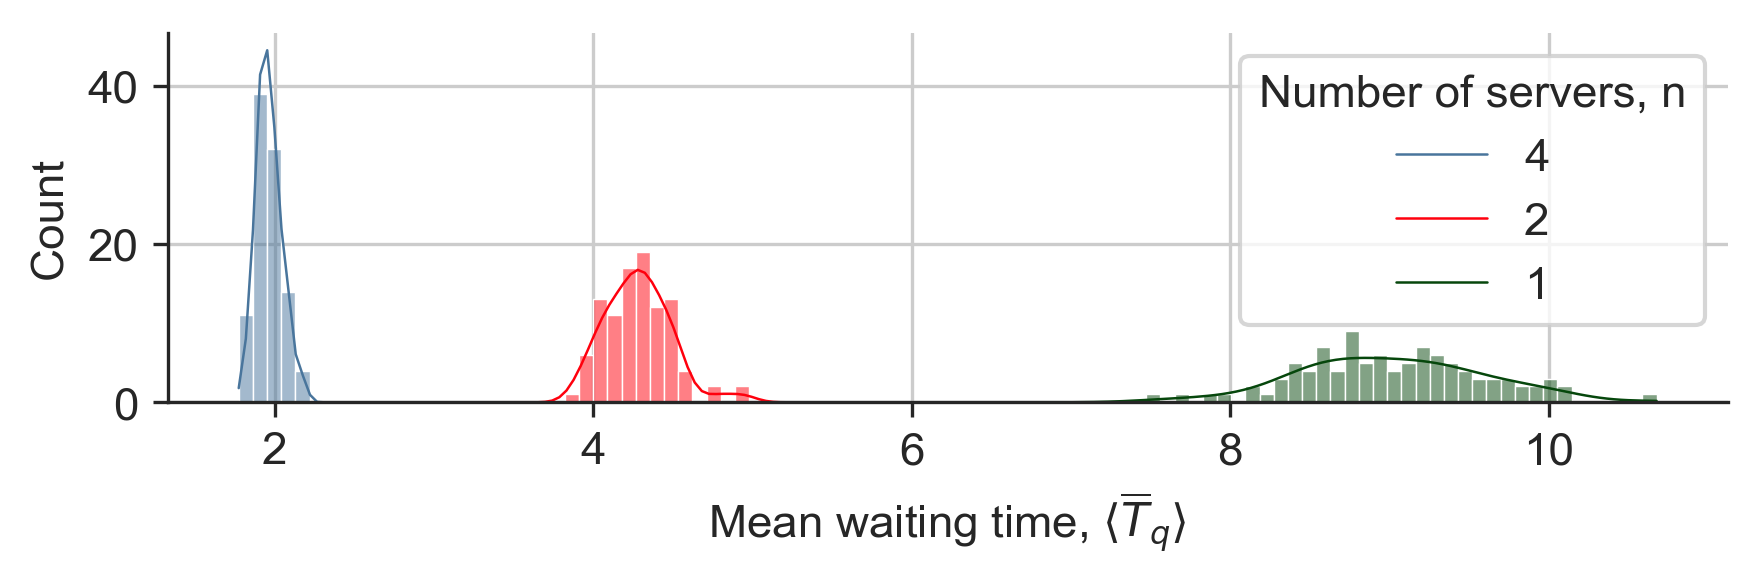

In [20]:
narrow_histogram_plotter("waiting_times_fullsave_124.npz", "Markovian_histogram.pdf")

Mean waiting time ± CI (95%) for 1-server queue: 4.500179 ± 0.041207
Mean waiting time ± CI (95%) for 2-server queue: 2.158022 ± 0.016360
Mean waiting time ± CI (95%) for 4-server queue: 1.002422 ± 0.005325


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


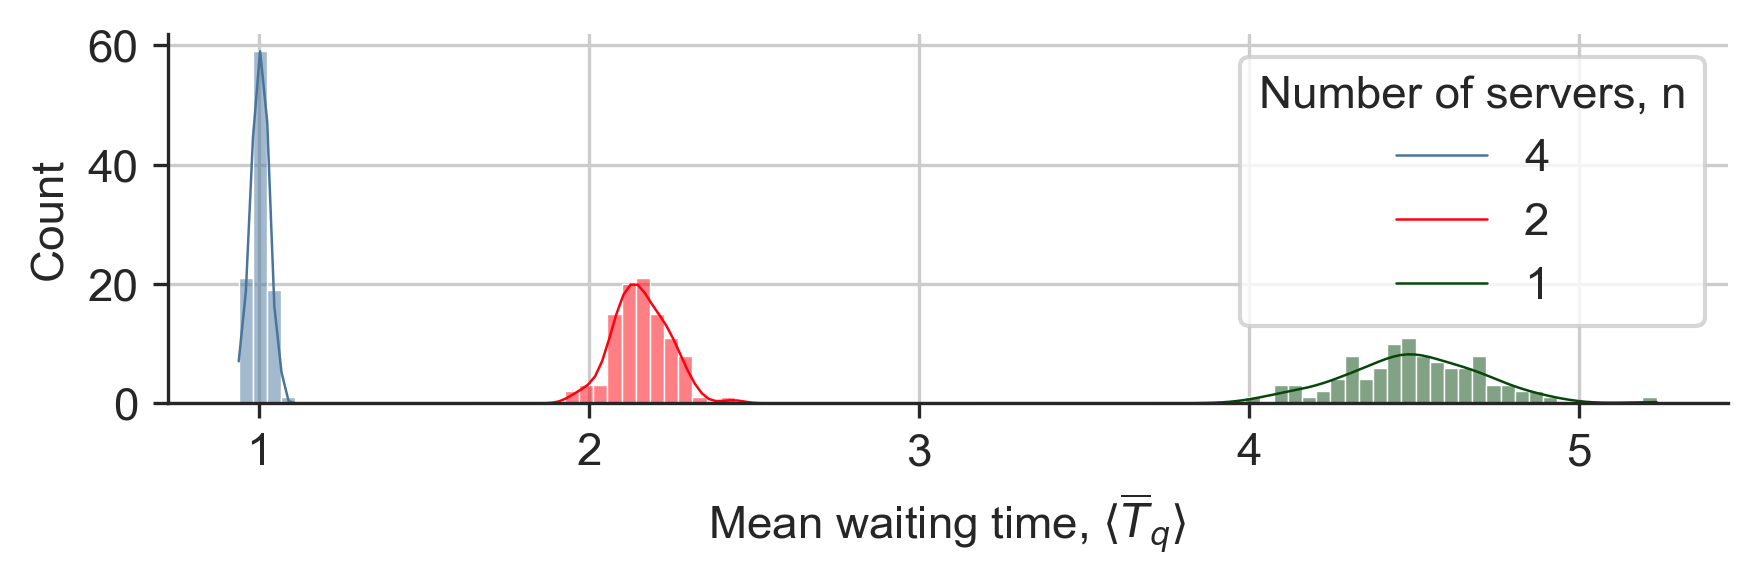

In [21]:
narrow_histogram_plotter("waiting_times_fullsave_124_deterministic.npz", "MD124_histogram.pdf")

Mean waiting time ± CI (95%) for 1-server queue: 0.585076 ± 0.002802
Mean waiting time ± CI (95%) for 2-server queue: 0.158139 ± 0.000763
Mean waiting time ± CI (95%) for 4-server queue: 0.028798 ± 0.000189


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


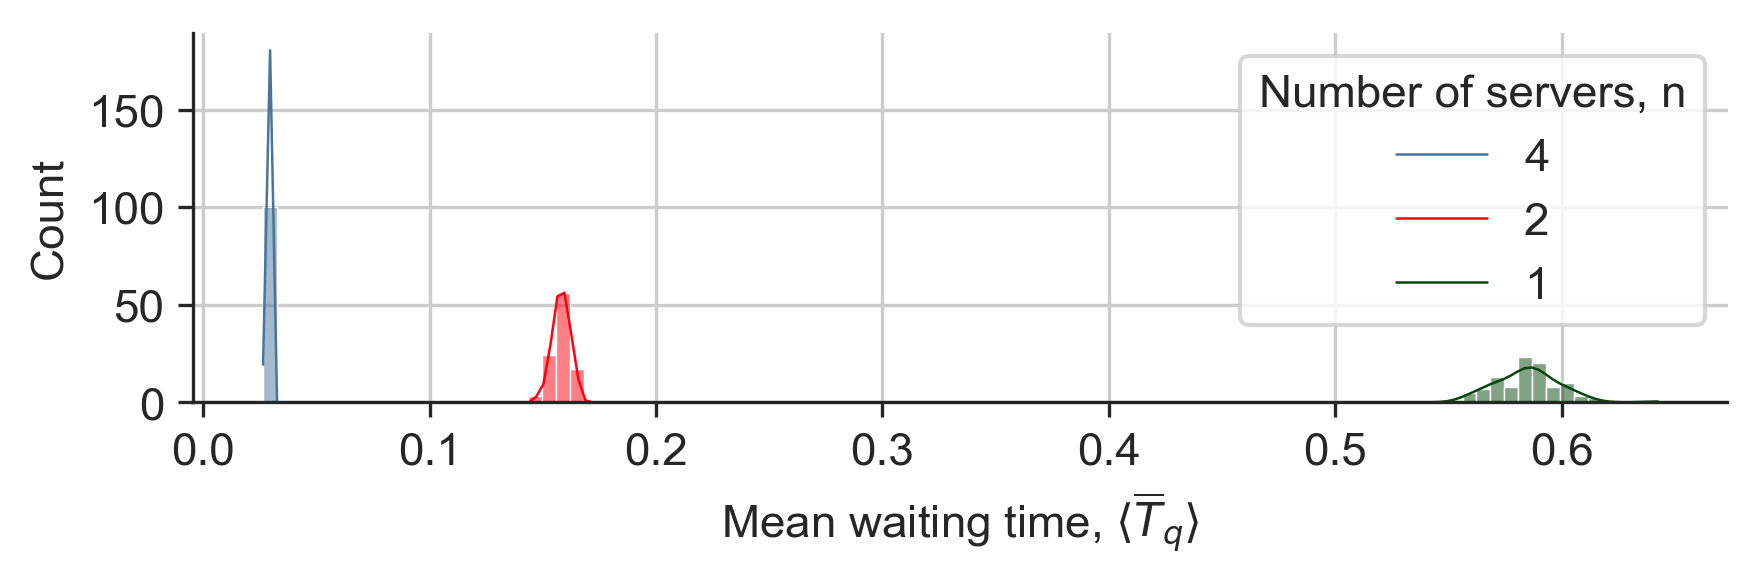

In [22]:
narrow_histogram_plotter("waiting_times_fullsave_124_hyper.npz", "MH124_histogram.pdf")